In [1]:
# Standard library imports:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lattice
from scipy.fft import fft, fftfreq

from LatticeConf import *

# Plot setup:
textprops = {"ha": "right", "va": "top"}
if os.uname().sysname == 'Darwin':
    %matplotlib inline

In [2]:
# Calculate Wannier functions:

Npoint=len(xarr)
xrange=2*max(xarr)

wannier_functions = []
for s in sarr:
    _, bs = lattice.eigenproblem(s, qarr, bands=n, kohns_phase=True)
    wf = lattice.wannier(xarr, bs)
    wannier_functions.append(np.real(wf))

dx = xarr[1] - xarr[0]

In [3]:
# Calculate TF:

T=xrange/Npoint; # sampling distance in position space
karr = fftfreq(Npoint, T)[:Npoint//2] # generating the array in the momentum space for FT calculation

FTwannier_functions = []
for i in range(len(sarr)):
    FTwannier_functions.append(fft(wannier_functions[i]))
    FTwannier_functions[i]=FTwannier_functions[i]/np.max(FTwannier_functions[i])
    FTwannier_functions[i]=FTwannier_functions[i][:len(FTwannier_functions[i])//2]
    FTwannier_functions[i]=np.concatenate((FTwannier_functions[i][::-1],FTwannier_functions[i][1:]))

karr=np.concatenate((-karr[::-1],karr[1:])) # to have a symmetric plot centered on k=0

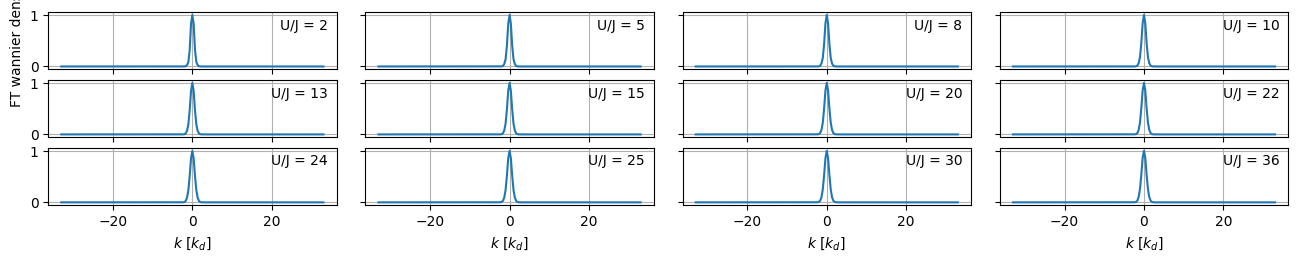

In [4]:
# Plot mod. square of TF:

fig, axes = plt.subplots(3, 4, figsize=(16, 2.5), sharey=True)
for i, ax in zip([6, 30, 42, 51, 59, 65, 76, 79, 82, 84, 91, 97], axes.flatten()):
    ax.plot(karr, np.abs(FTwannier_functions[i])**2)#,label='$s={}E_r$'.format(Varr[i]))
    # ax.plot(karr,np.exp(-karr**2*(4/np.sqrt(Varr[i]))),'--')#label='Approx. Gauss. $s={}E_r$'.format(Varr[0]))
    # ax.set_xlim(0,3)
    ax.set_xlabel('$k$ [$k_d$]')
    ax.grid()
    ax.text(.97, .9, f"U/J = {np.round(uj['U/J'].iloc[i]):.0f}", textprops, transform=ax.transAxes)
axes.flatten()[0].set_ylabel("FT wannier density")
plt.subplots_adjust(wspace=.1)
#plt.ylabel('Density [a.u.]')

plt.show()

# Relating quantities measured in the FBZ to systemwide quantites

We measure $N_0 \equiv N_{\mathbf{k} = \mathbf{0}}$ and $N_{\mathrm{FBZ}}$ and want to relate these quantities to $N_{\mathrm{BEC}}$ and $N_{\mathrm{tot}}$ using the Wannier functions $w_{n, j}(\mathbf{x}) = \sqrt{\frac{d}{2\pi}} \int_{\mathrm{FBZ}} \mathrm{d}\mathbf{q} \psi_{n, \mathbf{q}}(x) e^{-ij\mathbf{q}d}$ where $j \in \mathbb{Z}$ corresponds to the index of the lattice site and $n = 0$ (omitted hereafter) to the index of the lowest lattice band in the tight-binding limit. The Fourier-transformed Wannier functions are denoted $\tilde{w}(\mathbf{k})$. In a 3D cubic lattice they factorize, so the atom number in momentum space is related to:

$N(\mathbf{k}) \sim |\tilde{w}(\mathbf{k})|^2 = |\tilde{w}(k_x)|^2 \times |\tilde{w}(k_y)|^2 \times |\tilde{w}(k_z)|^2$

For the zero-momentum mode of the lowest energy state in the trap this implies simply:

$ \displaystyle  N_0 \sim |\tilde{w}(0)|^6$

The other condensed atoms $N_{\mathrm{BEC}} - N_0$ are dispersed over the diffraction peaks of order > 1:

$ \displaystyle N_{\mathrm{BEC}} \sim \sideset{}{'}\sum_{\mathbf{k}}|\tilde{w}(\mathbf{k})|^2$

where the sum runs over all diffraction peaks including the 0th order. Example: 2nd-order diffraction peak at $\mathbf{k}/k_d = (1, -1, 0)$: $|\tilde{w}(\mathbf{k})|^2 = |\tilde{w}(k_d)|^2 \times |\tilde{w}(-k_d)|^2 \times |\tilde{w}(0)|^2 = |\tilde{w}(k_d)|^4$ with the normalization of the Wannier functions to 1 at the origin. To calculate $N_{\mathrm{BEC}}$ for a specific diffraction order $n \in \mathbb{Z}$, let the sum run over all Miller indices $\mathbf{k}/k_d = (h, k, l)$ such that $|h| + |k| + |l| = n$.

The atom number of the first Brillouin zone (FBZ) is given by:

$ \displaystyle N_{\mathrm{FBZ}} \sim \left( \int_{-k_d/2}^{k_d/2}\mathrm{d}k|\tilde{w}(k)|^2 \right)^3$

and the corresponding total atom number by:

$ \displaystyle N_{\mathrm{tot}} \sim \left( \int_{-\infty}^{\infty}\mathrm{d}k|\tilde{w}(k)|^2 \right)^3$

In [5]:
# Calculate quantities:

dk = karr[1] - karr[0]

k_0_idx = np.where(karr==0)[0][0]

k_bec_idxs = np.where([i.is_integer() for i in karr])[0]

# print(karr[k_bec_idxs])

fbz_idxs = [i for i in range(len(karr)) if -0.5 <= karr[i] < 0.5]

n_0 = np.zeros_like(sarr)
n_bec = np.zeros_like(sarr)
n_fbz = np.zeros_like(sarr)
n_tot = np.zeros_like(sarr)
f_c_fbz = np.zeros_like(sarr)
f_c_tot = np.zeros_like(sarr)

# N_0:

for uj_idx, _ in enumerate(sarr):

    n_0[uj_idx] = abs(FTwannier_functions[uj_idx][k_0_idx])**2

# N_BEC:
    
n_max = int(max(karr))

miller_indices = pd.MultiIndex.from_product([
    [-n_max + l for l in range(2 * n_max + 1)],
    [-n_max + l for l in range(2 * n_max + 1)],
    [-n_max + l for l in range(2 * n_max + 1)]
    ]).to_numpy()

miller_indices = miller_indices[np.where([abs(h) + abs(k) + abs(l) <= n_max for (h, k, l) in miller_indices])]

mapping = {k: v for k, v in zip([-n_max + i for i in range(2 * n_max + 1)], k_bec_idxs)}

for uj_idx, _ in enumerate(sarr):
    
    n_bec[uj_idx] = 0
    
    for (h, k, l) in miller_indices:

        h_idx = mapping[h]
        k_idx = mapping[k]
        l_idx = mapping[l]
        
        # if uj_idx == 0: print((int(karr[h_idx]), int(karr[k_idx]), int(karr[l_idx])))

        n_bec[uj_idx] += (
            abs(FTwannier_functions[uj_idx][h_idx])**2
            * abs(FTwannier_functions[uj_idx][k_idx])**2
            * abs(FTwannier_functions[uj_idx][l_idx])**2)
                
    n_fbz[uj_idx] = (sum(dk*abs(FTwannier_functions[uj_idx][fbz_idxs])**2))**3
    n_tot[uj_idx] = (sum(dk*abs(FTwannier_functions[uj_idx][:])**2))**3

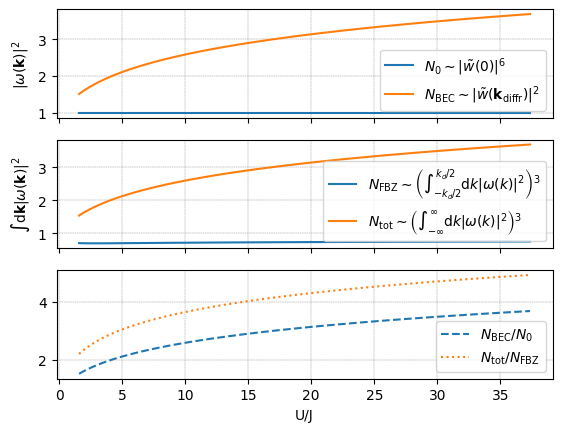

In [11]:
# Plot results as a function of U/J:

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(
    uj['U/J'],
    n_0,
    label=r'$N_0 \sim |\tilde{w}(0)|^6$'
    )
axs[0].plot(
    uj['U/J'],
    n_bec,
    label=r'$N_{\mathrm{BEC}} \sim |\tilde{w}(\mathbf{k}_{\mathrm{diffr}})|^2$'
    )
axs[1].plot(
    uj['U/J'],
    n_fbz,
    label=r'$N_{\mathrm{FBZ}} \sim \left( \int_{-k_d/2}^{k_d/2}\mathrm{d}k |\omega (k)|^2 \right)^3$'
    )
axs[1].plot(
    uj['U/J'],
    n_tot,
    label=r'$N_{\mathrm{tot}} \sim \left( \int_{-\infty}^{\infty}\mathrm{d}k |\omega (k)|^2 \right)^3$'
    )
axs[2].plot(
    uj['U/J'],
    n_bec / n_0,
    linestyle='--',
    label=r'$N_{\mathrm{BEC}} / N_0$'
    )
axs[2].plot(
    uj['U/J'],
    n_tot / n_fbz,
    linestyle=':',
    label=r'$N_{\mathrm{tot}} / N_{\mathrm{FBZ}}$'
    )
for idx, ax in enumerate(axs):
    if idx==len(axs)-1:
        ax.set_xlabel('U/J')
    elif idx==len(axs)-2:
        ax.set_ylabel(r'$\int\mathrm{d}\mathbf{k} |\omega (\mathbf{k})|^2$')
    else:
        ax.set_ylabel(r'$|\omega (\mathbf{k})|^2$')
    ax.legend()
    ax.set_axisbelow(True)    
    ax.xaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.grid(visible=True)

plt.show()